Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/opc/anaconda3/envs/pt/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/opc/anaconda3/envs/pt/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'Trainer' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/opc/anaconda3/envs/pt/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/opc/anaconda3/envs/pt/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'Trainer' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/opc/anaconda3/envs/pt/lib/python3.

Accuracy of the model: 15.02%


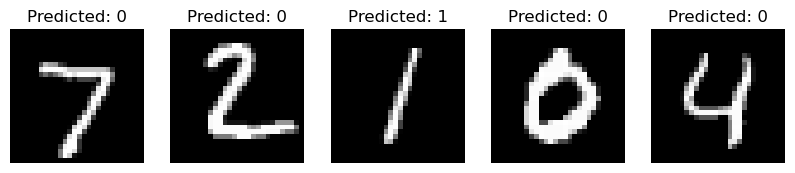

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.multiprocessing as mp

# 确保使用多进程
mp.set_start_method('spawn', force=True)

# 数据转换
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为 Tensor
    transforms.Normalize((0.5,), (0.5,))  # 归一化
])

# 下载训练集和测试集
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 定义神经网络模型
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # 第一层
        self.fc2 = nn.Linear(128, 64)        # 第二层
        self.fc3 = nn.Linear(64, 10)         # 输出层

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 展平图像
        x = torch.relu(self.fc1(x))  # 第一层激活
        x = torch.relu(self.fc2(x))  # 第二层激活
        x = self.fc3(x)  # 输出层
        return x

# 定义训练类
class Trainer:
    def __init__(self, model, criterion, optimizer, trainloader, num_epochs):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.num_epochs = num_epochs

    def train(self, rank):
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for i, (images, labels) in enumerate(self.trainloader):
                self.optimizer.zero_grad()  # 清零梯度

                # 前向传播
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # 反向传播和优化
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            print(f'Rank [{rank}], Epoch [{epoch + 1}/{self.num_epochs}], Loss: {running_loss / len(self.trainloader):.4f}')

# 测试函数
def test(model, testloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model: {accuracy:.2f}%')
    return accuracy

# 主函数
def main():
    num_epochs = 5  # 训练轮数
    model = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    trainer = Trainer(model, criterion, optimizer, trainloader, num_epochs)

    # 创建进程
    processes = []
    for rank in range(4):  # 4个进程
        p = mp.Process(target=trainer.train, args=(rank,))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    # 测试模型
    test(model, testloader)

    # 可视化一些测试结果
    def imshow(img):
        img = img / 2 + 0.5  # 反归一化
        plt.imshow(img.numpy(), cmap='gray')
        plt.axis('off')

    dataiter = iter(testloader)
    images, labels = next(dataiter)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    # 显示前5个结果
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        imshow(images[i][0])
        plt.title(f'Predicted: {predicted[i].item()}')
    plt.show()

if __name__ == '__main__':
    main()


In [9]:
import sys
print(sys.prefix)

/home/opc/anaconda3/envs/pt
